In [541]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import re
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [542]:
df_initial=pd.read_csv(r'C:\Users\ADITYA\OneDrive\Desktop\important files\berlin-airbnb-data\listings_summary.csv')

In [543]:
print("The dataset has {} rows and {} columns.".format(*df_initial.shape))

The dataset has 22552 rows and 96 columns.


In [544]:
print("It contains {} duplicates.".format(df_initial.duplicated().sum()))

It contains 0 duplicates.


In [545]:
print(df_initial.columns)
df_initial.head(1)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76


In [546]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_initial[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 22552 rows and 23 columns - after dropping irrelevant columns.


In [547]:
print(df_raw.room_type.value_counts())
print('###########')
print(df_raw.room_type.value_counts(normalize=True))

Private room       11534
Entire home/apt    10722
Shared room          296
Name: room_type, dtype: int64
###########
Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64


In [548]:
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Camper/RV                 0.000488
Houseboat                 0.000488
Villa                     0.000443
Aparthotel                0.000310
Pension (South Korea)     0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Train                     0.000089
Castle                    0.000089
Casa particular (Cuba)    0.000089
In-law                    0.000044
Chalet              

# Preprocessing prices

In [549]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00


In [550]:
print(df_raw.price.isna().sum())
print(df_raw.cleaning_fee.isna().sum())

0
7146


#There are plenty of Nan's. It's more than likely that these hosts do not charge any extra cleaning fee. So let's simply replace these null values with $0.00:

In [551]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

In [552]:
df_raw.security_deposit.isna().sum()
df_raw.security_deposit.fillna('$0.00',inplace=True)
df_raw.security_deposit.isna().sum()

0

In [553]:
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [554]:
df_raw['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

# Eliminating Outliners

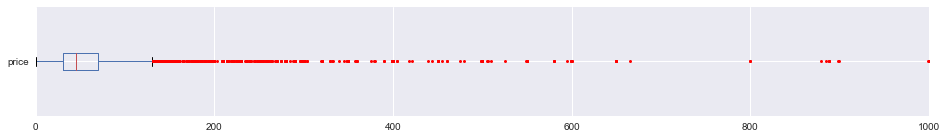

In [555]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

75% of the apartments charge up to 68€ - but the maximum value is 9000€. Let's decide on a limit of 400€, after which the outliers seem to "fringe", and drop all records that charge more than that. Oddly enough, we have prices set to zero. So let's drop those records, too:

In [556]:
(df_raw['price']==0).value_counts()

False    22544
True         8
Name: price, dtype: int64

In [557]:
(df_raw['price']>=400).value_counts()

False    22435
True       117
Name: price, dtype: int64

In [558]:
df_raw.drop(df_raw[ (df_raw.price > 400) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [559]:
df_raw['price'].describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [560]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df_raw.shape))

The dataset has 22441 rows and 23 columns - after being price-wise preprocessed.


# Dealing with missing values

In [561]:
df_raw.isna().sum()

space                            8503
description                       202
host_has_profile_pic               25
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21996
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
dtype: int64

In [562]:
# drop columns with too many Nan's
df_raw.drop(columns=['square_feet', 'space'], inplace=True)

In [563]:
# drop rows with NaN's in bathrooms and bedrooms
df_raw.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [564]:
print(df_raw.host_has_profile_pic.unique())
df_raw.host_has_profile_pic.value_counts()

['t' 'f' nan]


t    22310
f       56
Name: host_has_profile_pic, dtype: int64

In [565]:
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [566]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

The dataset has 22391 rows and 21 columns - after having dealt with missing values.


# Feature Engineering 1: Distance to Centroid of Berlin

In [567]:
df_raw.columns

Index(['description', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'bed_type', 'amenities', 'price',
       'cleaning_fee', 'security_deposit', 'extra_people', 'guests_included',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy'],
      dtype='object')

Location is always an important factor in lodging services. To make it more descriptive, I decided to calculate each accommodation's distance to the so-called centroid of Berlin instead of just relying on the neighbourhoods or areas.

For our convenience, let's write a quick function that does this, apply it to each accommodation, and store the values in a new column:

Googled the latitide and logitude for the center point of berlin(52.5027778, 13.404166666666667)

In [568]:
from geopy.distance import great_circle
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [569]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)
df_raw['distance'].head()

id
2015    3.533182
2695    5.085573
3176    3.695677
3309    3.755285
7071    4.550423
Name: distance, dtype: float64

# 2.5. Feature Engineering 2: Lodging Size

One of the most important pieces of information for predicting the rate is the size. Since the column square_feet was heavily filled with null values, we dropped it in the previous section.

Let's check, if the column description reveals any information about size instead:

In [570]:
#list(df_raw.description[:10])

We can see that most of the descreption contains the size of the room.
The description column seems to be rich in content. Let's extract

* all double-digit or three-digit numbers
* that are followed by one of the two characters "s" or "m" (covering "sqm", "square meters", "m2" etc.) and
* may or may not be connected by white space.

Single- or more than three-digit numbers for accommodation sizes are quite unlikely.

In [571]:
# extract numbers 
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")

# change datatype of size into float
df_raw['size'] = df_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3), '%')

NaNs in size_column absolute:      11721
NaNs in size_column in percentage: 0.523 %


In [572]:
df_raw[['description', 'size']].head(5)

,description,size
id,,
2015,Great location! 30 of 75 sq meters. This wood...,75.0
2695,In the summertime we are spending most of our ...,25.0
3176,This beautiful first floor apartment is situa...,68.0
3309,First of all: I prefer short-notice bookings. ...,26.0
7071,Cozy and large room in the beautiful district ...,20.0


In [573]:
# drop description column
df_raw.drop(['description'], axis=1, inplace=True)

##Predicting missing values with regression

As calculated further up, half of our records still don't have a size. That means we have a problem! Dropping these records isn't an option as we would loose too much valuable information. Simply replacing it with the mean or median makes no sense. That leaves a third option: predict the missing value with a Machine Learning Algorithm. To not make it too complicated, we'll only use numerical features. Next, we have to split our data into

* a) a training set where we have sizes and
* b) a test set where we don't.

Selecting the features which are numerical

In [574]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22391 entries, 2015 to 29867352
Data columns (total 22 columns):
host_has_profile_pic            22391 non-null object
neighbourhood_group_cleansed    22391 non-null object
latitude                        22391 non-null float64
longitude                       22391 non-null float64
property_type                   22391 non-null object
room_type                       22391 non-null object
accommodates                    22391 non-null int64
bathrooms                       22391 non-null float64
bedrooms                        22391 non-null float64
bed_type                        22391 non-null object
amenities                       22391 non-null object
price                           22391 non-null float64
cleaning_fee                    22391 non-null float64
security_deposit                22391 non-null float64
extra_people                    22391 non-null float64
guests_included                 22391 non-null int64
minimum_nights 

In [575]:
# filter out sub_df to work with
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [576]:
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [577]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (10670, 10)
Shape of Test Data:     (11721, 10)

Shape of X_train: (10670, 9)
Shape of X_test: (11721, 9)

Shape of y_train: (10670,)


In [578]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [579]:
# making predictions
y_test = linreg.predict(X_test)
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(11721, 1)


,size
0,56.697281
1,97.756906
2,75.831592
3,88.778838
4,60.680846


In [580]:
print(X_test.shape)
X_test.head()

(11721, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509


To combine y_test and X_test back to our full test_dataframe, we have to create a bit of a circuit. As we can see here, the X_test dataframe has a specific index that's not compatible with y_test, where the numbers simply start from 0 onwards. So we need to provide y_test with the X_test index to make sure everyting fits together.

In [581]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
14325,56.697281
20858,97.756906
21869,75.831592
22415,88.778838
28156,60.680846


In [582]:
new_test_data = pd.concat([X_test, y_test], axis=1)
new_test_data['size'].isna().sum()

0

In [583]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()


(22391, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012297,56.697281
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3.807207,97.756906
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061292,75.831592
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,1.868255,88.778838
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886509,60.680846


In [584]:
sub_df_new['size'].isna().sum()

0

In [585]:
# prepare the multiple columns before concatening
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)
# concate back to complete dataframe
df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head(2)

(22391, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,3.533182,75.0,...,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,5.085573,25.0,...,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,f,f,flexible


In [586]:
print(df['size'].isna().sum())
df['size'].describe()

0


count    22391.000000
mean        60.297112
std         80.937597
min          0.000000
25%         25.000000
50%         49.573940
75%         65.014837
max        980.000000
Name: size, dtype: float64

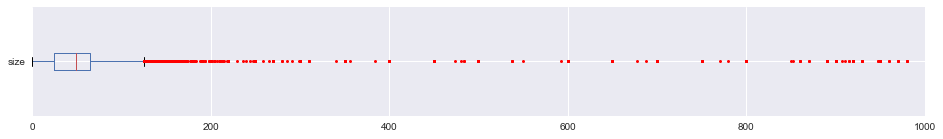

In [587]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [588]:
(df['size']>=300).value_counts()

False    21974
True       417
Name: size, dtype: int64

In [589]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [590]:
df.shape

(21958, 22)

# Feature Engineering 3: Lodging Amenities

I'm interested in what amenities hosts offer their guests, and in order to enrich our prediction, whether we can determine what some of the more special and/or rare amenities might be that make a property more desirable.

In [591]:
df['amenities'].head(5)

2015    {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...
2695    {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...
3176    {Internet,Wifi,Kitchen,"Buzzer/wireless interc...
3309    {Internet,Wifi,"Pets allowed","Pets live on th...
7071    {Wifi,Heating,"Family/kid friendly",Essentials...
Name: amenities, dtype: object

In [592]:
from collections import Counter
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(10)

[('Wifi', 20952),
 ('Kitchen', 20809),
 ('Heating', 20657),
 ('Essentials', 19811),
 ('Washer', 18071),
 ('Hair dryer', 14474),
 ('Laptop friendly workspace', 14095),
 ('Hangers', 13514),
 ('Iron', 10876),
 ('Shampoo', 10339)]

In [593]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

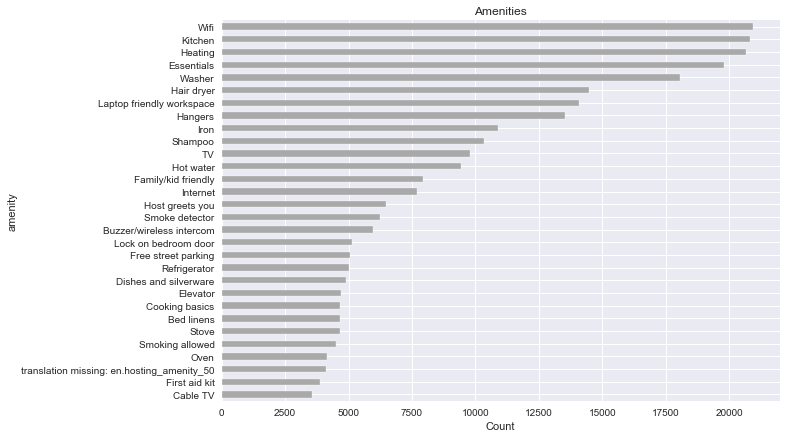

In [594]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

Let's add columns with amenities that are somewhat unique and not offered by all hosts:

* a laptop-friendly workspace
* a TV
* kid friendly accommodation
* smoker friendly and
* being greeted by the host.
After doing this, let's drop the original column:

In [595]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [596]:
df.drop(['amenities'], axis=1, inplace=True)

# Exploratory Data Analysis (EDA)

Price Differences on a Map

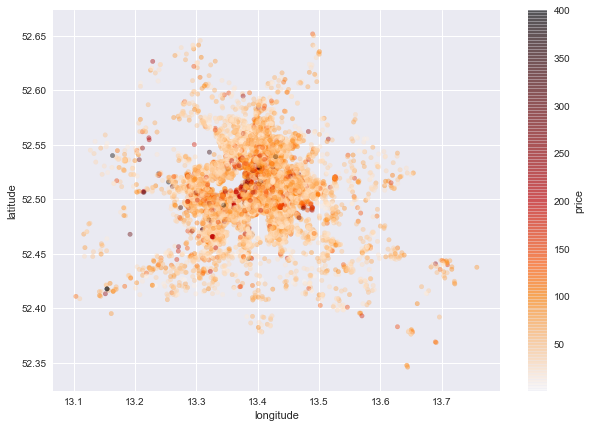

In [597]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

Price Differences by Neighbourhood

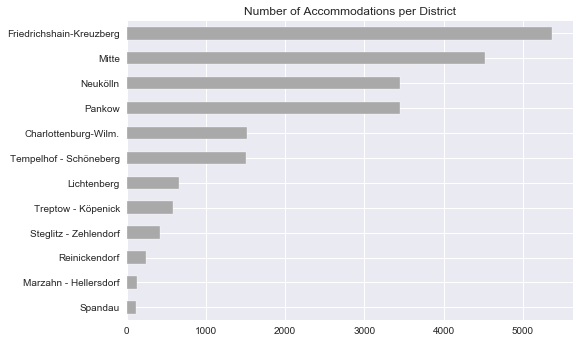

In [598]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District');

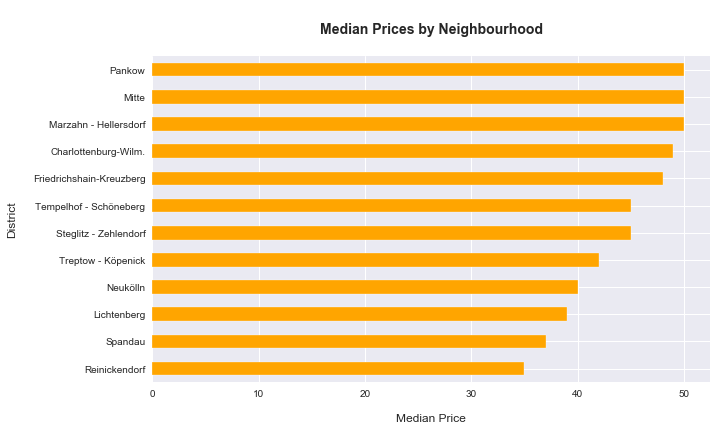

In [599]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)
# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='orange')
plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

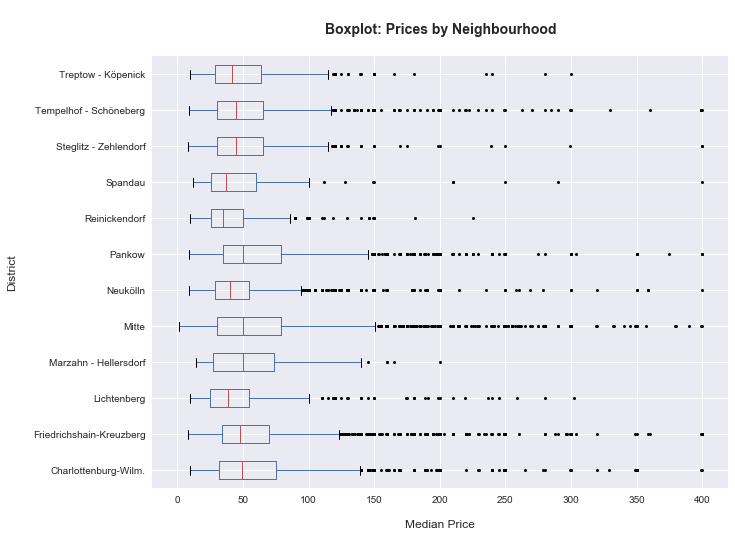

In [600]:
red_square = dict(markerfacecolor='black', markeredgecolor='black', marker='.')

df.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

Price Differences by Accommodation Distance to Center of Berlin

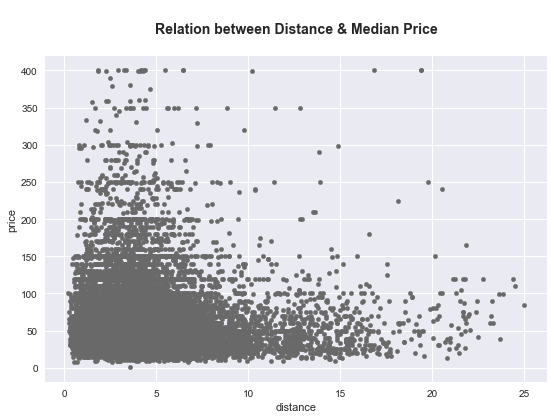

In [601]:
df.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

Price Differences by Accommodation Size

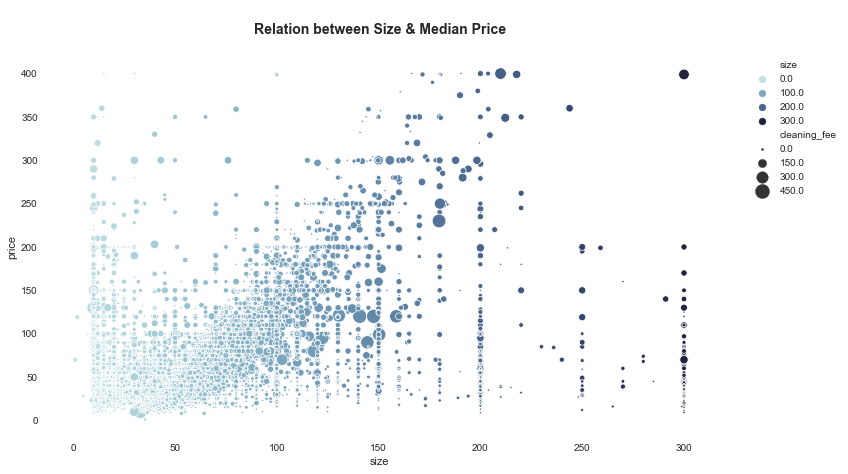

In [602]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Price Differences by Number of Bedrooms

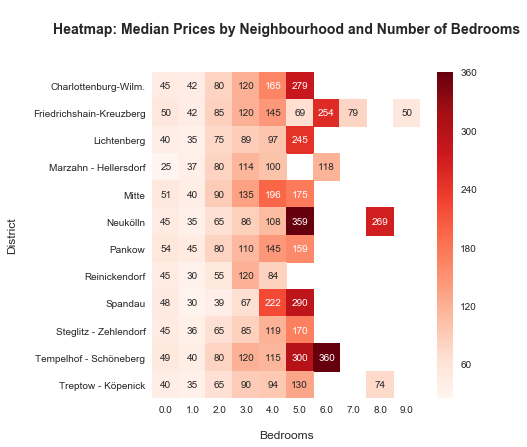

In [603]:
plt.figure(figsize=(6,6))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

Price Differences by Cancellation Policy

In [604]:
df['cancellation_policy'].value_counts()

flexible                       8886
moderate                       6929
strict_14_with_grace_period    6085
super_strict_30                  48
super_strict_60                  10
Name: cancellation_policy, dtype: int64

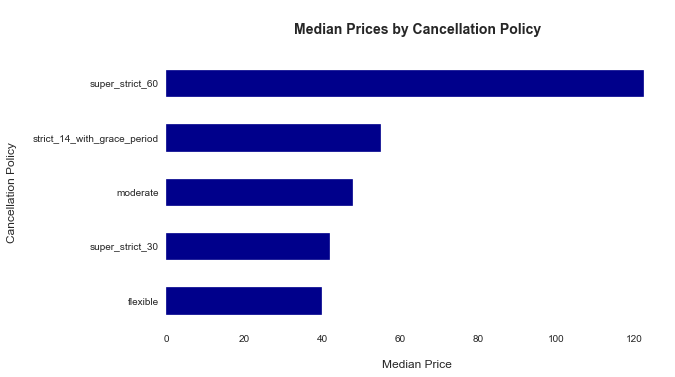

In [605]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');


# Modeling the Data

Preparing Target and Features

In [606]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'distance',
       'size', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'Laptop_friendly_workspace', 'TV',
       'Family_kid_friendly', 'Host_greets_you', 'Smoking_allowed'],
      dtype='object')

In [607]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21958 entries, 2015 to 29867352
Data columns (total 26 columns):
accommodates                    21958 non-null int64
bathrooms                       21958 non-null float64
bedrooms                        21958 non-null float64
price                           21958 non-null float64
cleaning_fee                    21958 non-null float64
security_deposit                21958 non-null float64
extra_people                    21958 non-null float64
guests_included                 21958 non-null int64
distance                        21958 non-null float64
size                            21958 non-null float64
host_has_profile_pic            21958 non-null object
neighbourhood_group_cleansed    21958 non-null object
latitude                        21958 non-null float64
longitude                       21958 non-null float64
property_type                   21958 non-null object
room_type                       21958 non-null object
bed_type     

In [608]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)

Now let's convert all string columns into categorical ones:

In [609]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [610]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

one-hot encoding, which creates a new column for each unique category in a categorical variable. Each observation receives a 1 in the column for its corresponding category (= "HOT") and a 0 in all other new columns. To conduct one-hot encoding, we use the pandas get_dummies function.

In [611]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()
# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [612]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [613]:
print(features_recoded.shape)
features_recoded.head(2)

(21958, 33)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,3.533182,75.0,4,...,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,5.085573,25.0,2,...,0,1,1,0,1,1,0,0,0,0


In [614]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

Normalizing the data

In [615]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

LinearRegression

In [616]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train,y_train)
reg.score(X_train, y_train)
y_pred_test_lin=reg.predict(X_test)
r2 = r2_score(y_test, y_pred_test_lin)
print(f"r2: {round(r2, 4)}")

r2: 0.5196


Ridge

In [617]:
from sklearn.linear_model import Ridge
ridgeReg = Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train,y_train)
pred_ridge = ridgeReg.predict(X_test)
r2 = r2_score(y_test, pred_ridge)
print(f"r2: {round(r2, 4)}")

r2: 0.519


Lasso

In [618]:
from sklearn.linear_model import Lasso
lassoReg = Lasso(alpha=0.01, normalize=True)
lassoReg.fit(X_train, y_train)
pred_lasso = lassoReg.predict(X_test)
#lassoReg.score(y_test, pred)
r2 = r2_score(y_test, pred_lasso)
print(f"r2: {round(r2, 4)}")

r2: 0.511


In [619]:
from sklearn.linear_model import ElasticNet
ENreg = ElasticNet(alpha=0.1, l1_ratio=0.5, normalize=False)
ENreg.fit(X_train,y_train)
pred_EN = ENreg.predict(X_test)
r2 = r2_score(y_test, pred_EN)
print(f"r2: {round(r2, 4)}")

r2: 0.5188


KNN

In [620]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred_test_knn=knn.predict(X_test)
r2 = r2_score(y_test, y_pred_test_knn)
print(f"r2: {round(r2, 4)}")

r2: 0.5236


In [621]:
from sklearn.svm import SVR
SVR = SVR(gamma='scale', C=1.0, epsilon=0.2)
SVR.fit(X_train, y_train) 
pred_svr=SVR.predict(X_test)
r2 = r2_score(y_test, pred_svr)
print(f"r2: {round(r2, 4)}")

r2: 0.4109


Random Forest

In [622]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
RF.fit(X_train, y_train)
y_pred_test_rf=RF.predict(X_test)
r2 = r2_score(y_test, y_pred_test_rf)
print(f"r2: {round(r2, 4)}")

r2: 0.6901


# Training an XGBoost Regressor

In [337]:
booster = xgb.XGBRegressor()

* n_estimators    = Number of trees one wants to build.
* learning_rate   = Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.
* max_depth   = Determines how deeply each tree is allowed to grow during any boosting round.
* colsample_bytree = Percentage of features used per tree.
* gamma   = Specifies the minimum loss reduction required to make a split.

In [435]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid1={'n_estimators':[100,150,200],
           'learning_rate':[0.01,0.05,0.1],
           'max_depth':[3,4,5,6,7],
           'colsample_bytree':[0.6,0.7,1],
           'gamma':[0.0,0.1,0.2]}

In [436]:
# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)
# train the tuned random forest
booster_grid_search.fit(X_train, y_train)
# print best estimator parameters found during the grid search
#print(booster_grid_search.best_params_)

[00:34:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=4,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5, 6, 7], 'colsample_bytree': [0.6, 0.7, 1], 'gamma': [0.0, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [437]:
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [438]:
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, 
                           max_depth=7, n_estimators=200, random_state=4)
booster.fit(X_train, y_train)

[00:43:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0.1,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=4,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [439]:
#y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [440]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 22.984


In [441]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.711


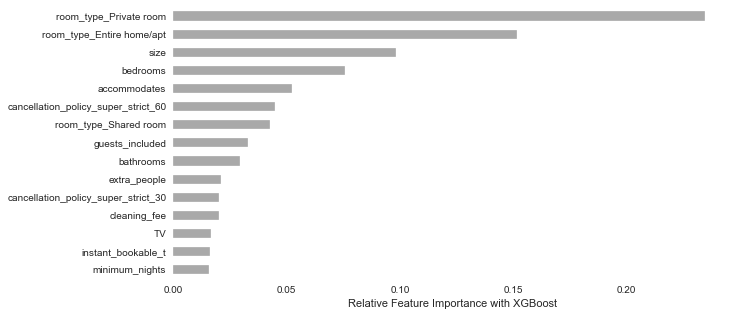

In [442]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');

The purpose of this analysis was to recommend a price to a "rookie" who is thinking to lending thier place to Ari BNB without any reviews or status. With this in mind, we can't recommend an exact price, but rather a range. 

Although, takinging the reviews and other features will definetly improve the accuracy and that type of analysis is for AIR BNB side.But, This Analysis is on the people side with the basic faeautres(size,amminites,room type...etc) with whatever he has how much can he expect from his place by lending his palce to AIR BNB.